In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler

from scipy.io import savemat, loadmat

In [159]:
import pyvista as pv

In [160]:
poro = loadmat('data_100_100_11/rock/rock_41.mat', simplify_cells=True)['poro']

In [161]:
p = pv.Plotter()

p.add_mesh(np.flip(poro))

ImportError: libGL.so.1: cannot open shared object file: No such file or directory

In [2]:
Jfolder = '/mnt/e/Placement-Control-Optim-CO2/Johansen/data'

actnum = np.loadtxt('{}/NPD5_ActiveCells.txt'.format(Jfolder), skiprows=1).flatten().reshape(100,100,11, order='F')
actnum_pad = np.pad(actnum, ((14,14),(14,14),(2,3)), mode='constant', constant_values=0)

actnum_l1 = actnum[...,0]
indexMap = np.argwhere(actnum_l1.flatten(order='F')).flatten(order='F')

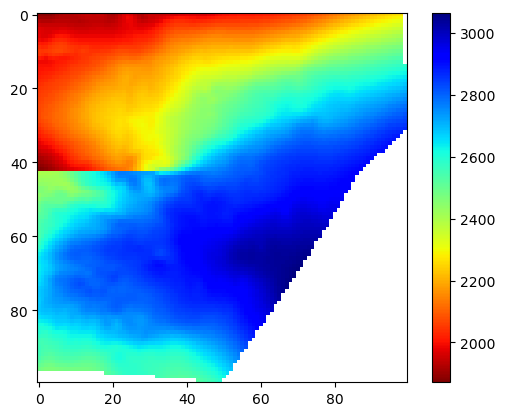

In [3]:
tops = loadmat('data_100_100_11/Gt_cells_z.mat', simplify_cells=True)['gtz']

tops_grid = np.zeros((100,100))
tops_grid_f = tops_grid.flatten()
tops_grid_f[indexMap] = tops

tops_grid = tops_grid_f.reshape(100,100, order='F')
tops_grid_masked = np.ma.masked_where(actnum_l1==0, tops_grid)

plt.imshow(tops_grid_masked, cmap='jet_r')
plt.colorbar()

In [9]:
n_realizations = 50
timesteps = []
saturation_f = np.zeros((n_realizations,41,8072))
pressure_f   = np.zeros((n_realizations,41,8072))

sec2year = 365.25 * 24 * 60 * 60
psi2pascal = 6894.76

for t in range(1,41):
    d = loadmat('data_100_100_11/VE_states/states_0.mat', simplify_cells=True)['var']
    timesteps.append(d[t]['time']/sec2year)
timesteps = [0] + timesteps

for i in range(n_realizations):
    d = loadmat('data_100_100_11/VE_states/states_{}.mat'.format(i), simplify_cells=True)['var']
    for t in range(len(d)):
        saturation_f[i,t] = d[t]['s'][:,1]
        pressure_f[i,t]   = d[t]['pressure']

In [17]:
saturation = np.zeros((n_realizations, len(timesteps), 100*100))
pressure   = np.zeros((n_realizations, len(timesteps), 100*100))

for i in range(n_realizations):
    for t in range(len(timesteps)):
        saturation[i,t][indexMap] = saturation_f[i,t]
        pressure[i,t][indexMap]   = pressure_f[i,t] / psi2pascal

saturation = saturation.reshape(n_realizations, len(timesteps), 100, 100)
pressure   = pressure.reshape(n_realizations, len(timesteps), 100, 100)
print(saturation.shape, pressure.shape)

(50, 41, 100, 100) (50, 41, 100, 100)


In [ ]:
co2_rho = 686.5266
mega    = 1e6

well_rates = {}
for i in range(n_realizations):
    d = loadmat('data_100_100_11/VE_states/states_{}.mat'.format(i), simplify_cells=True)['var']
    d0 = d[1]['wellSol']
    nw = 1 if len(d0) > 3 else len(d0)
    wr = np.zeros((len(timesteps), nw))
    for w in range(nw):
        for t in range(1,len(timesteps)):
            wr[t,w] = d[t]['wellSol'][w]['val'] if nw > 1 else  d[t]['wellSol']['val']
    well_rates[i] = wr * co2_rho * sec2year / 1e3 / mega

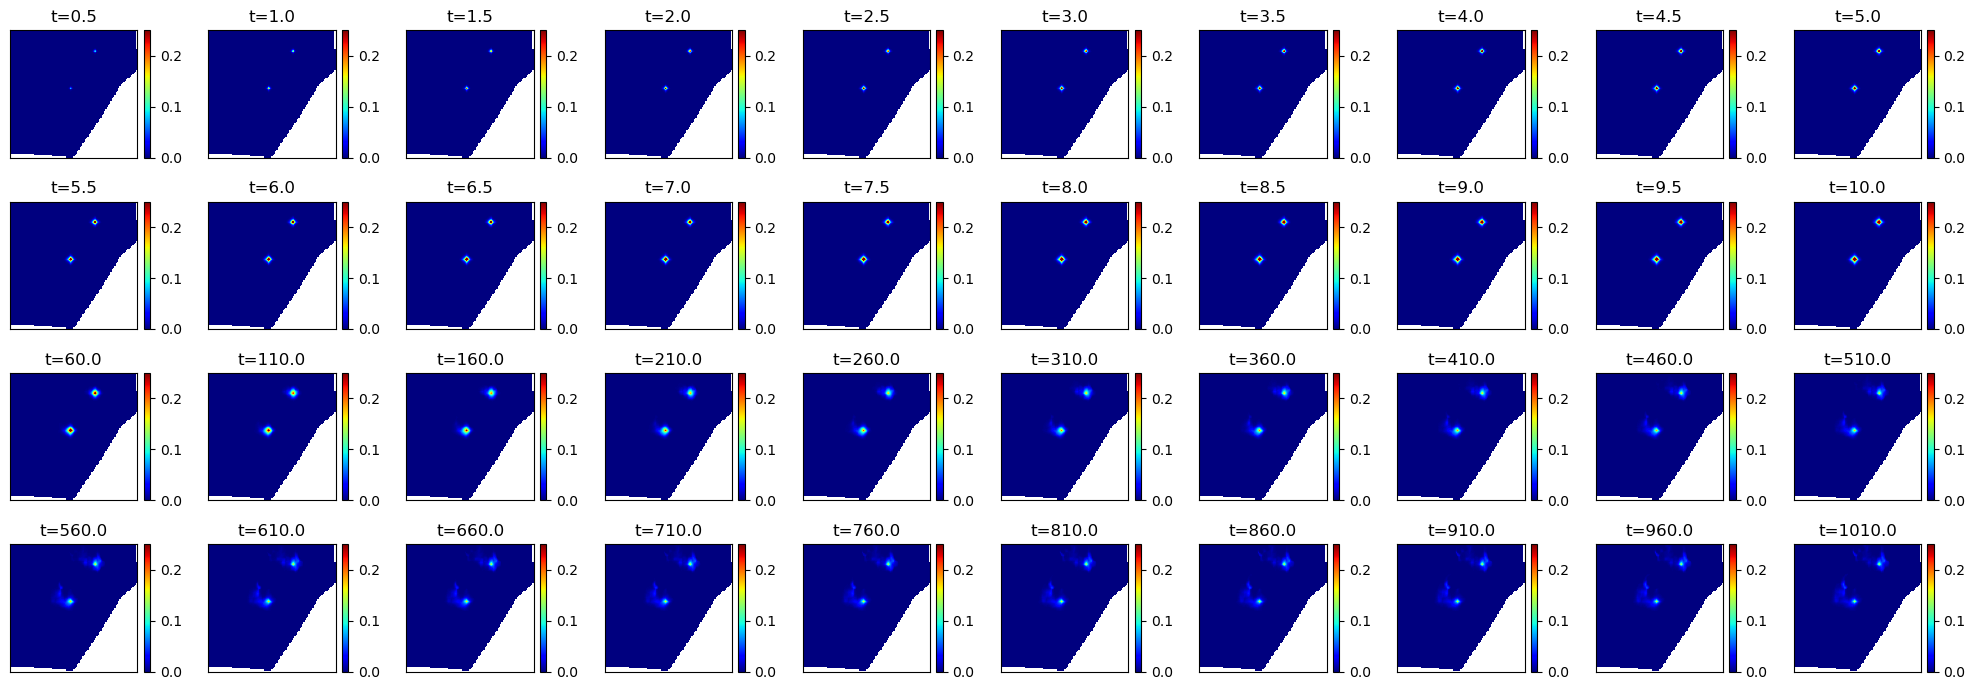

In [145]:
realization = 22

plt.figure(figsize=(20,7))
k = 0
for i in range(4):
    for j in range(10):
        plt.subplot(4,10,k+1)
        k += 1
        sat_masked = np.ma.masked_where(actnum_l1==0, saturation[realization,k])
        im = plt.imshow(sat_masked, cmap='jet', vmin=0, vmax=0.25)
        plt.title('t={:.1f}'.format(round(timesteps[k], 2)))
        plt.colorbar(im, pad=0.04, fraction=0.046)
        plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()

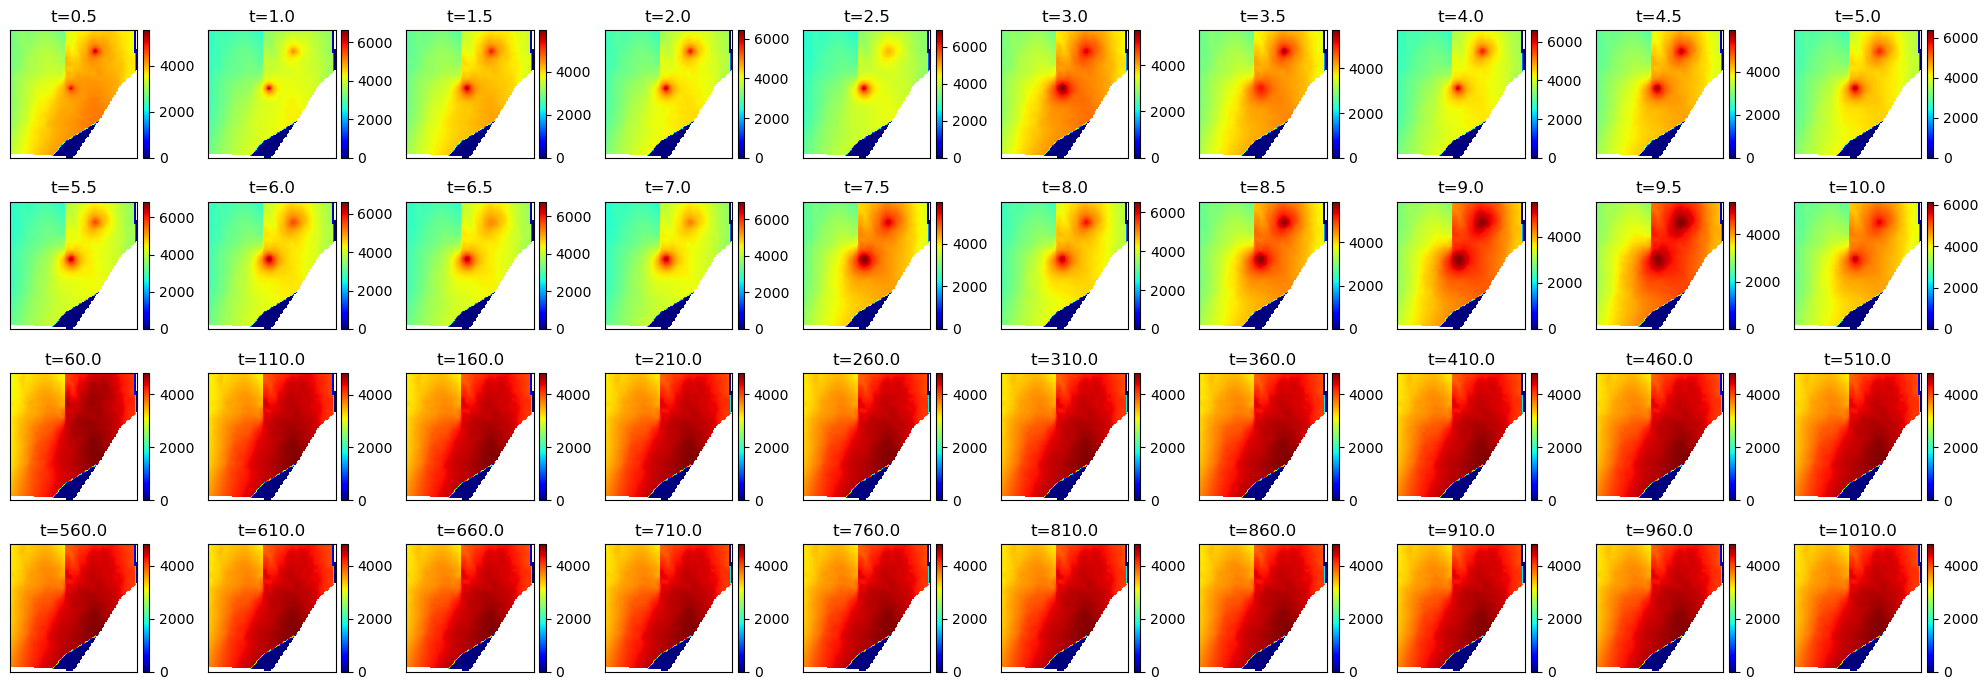

In [146]:
plt.figure(figsize=(20,7))
k = 0
for i in range(4):
    for j in range(10):
        plt.subplot(4,10,k+1)
        k += 1
        pres_masked = np.ma.masked_where(actnum_l1==0, pressure[realization,k])
        im = plt.imshow(pres_masked, cmap='jet')
        plt.title('t={:.1f}'.format(round(timesteps[k], 2)))
        plt.colorbar(im, pad=0.04, fraction=0.046)
        plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()

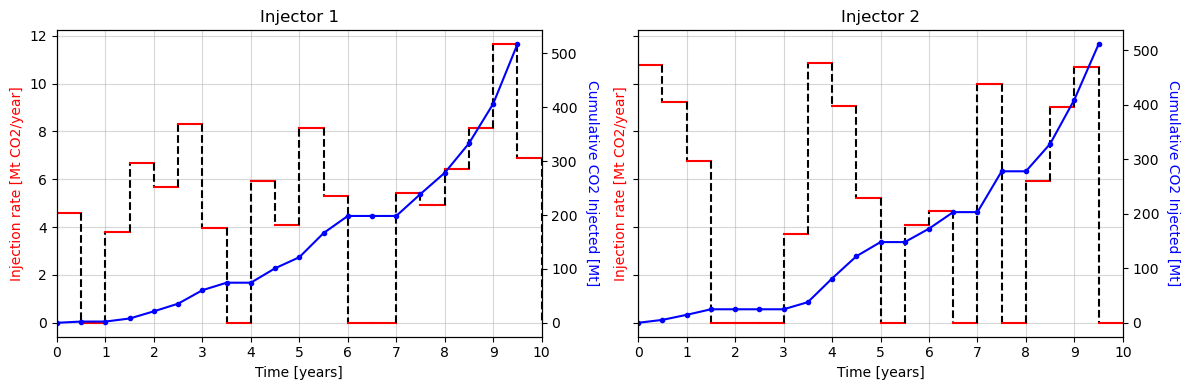

In [144]:
fig, axs = plt.subplots(1, well_rates[realization].shape[1], figsize=(12,4), sharex=True, sharey=True)
for w in range(well_rates[realization].shape[1]):
    ax = axs[w]
    ax.set(xlabel='Time [years]', xticks=range(11), xticklabels=range(11), xlim=(0,10), title='Injector {}'.format(w+1))
    ax.set_ylabel('Injection rate [Mt CO2/year]', c='r')
    ax.grid(True, which='both', alpha=0.5)
    ax2 = ax.twinx()
    ax2.plot(timesteps[:20], np.cumsum(well_rates[realization][:20,w]*timesteps[:20]), color='b', marker='.')
    ax2.set_ylabel('Cumulative CO2 Injected [Mt]', color='b', rotation=270, labelpad=15)
    for t in range(1,21):
        ax.plot([timesteps[t-1], timesteps[t]], [well_rates[realization][t,w], well_rates[realization][t,w]], 'r')
        ax.vlines(timesteps[t], well_rates[realization][t,w], well_rates[realization][t+1,w], ls='--', color='k')    
plt.tight_layout()
plt.show()

In [129]:
report = loadmat('data_100_100_11/VE_reports_NoFlowBC/reports_21.mat', simplify_cells=True)['var']
sec2year = 365.25 * 24 * 60 * 60
mt_of_co2 = 686.5266 * 1e6

t = []
for i in range(31):
    t.append(report[i]['t']/sec2year)

m = np.zeros((31,8))
for i in range(31):
    for j in range(8):
        m[i,j] = report[i]['masses'][j] / mt_of_co2

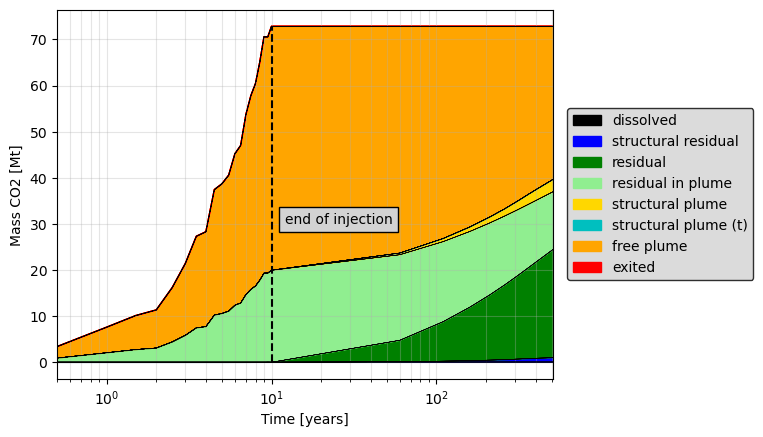

In [130]:
colors = ['k','blue','green','lightgreen','gold','c','orange','r']
labels = ['dissolved','structural residual', 'residual','residual in plume','structural plume', 'structural plume (t)','free plume', 'exited']

for i in range(8):
    plt.plot(t, np.cumsum(m, axis=1), color='k', lw=0.25)
    plt.fill_between(t, np.cumsum(m, axis=1)[:,i], np.cumsum(m, axis=1)[:,i-1], label=labels[i], color=colors[i])

plt.vlines(10, 0, np.cumsum(m,1).max(), color='k', ls='--')
plt.text(12, 30, 'end of injection', bbox=dict(facecolor='lightgray', edgecolor='k'))

plt.xscale('log')
plt.xlim(0.5, 510)
plt.legend(bbox_to_anchor=(1.015, 0.5), loc='center left', facecolor='lightgrey', edgecolor='k')
plt.xlabel('Time [years]'); plt.ylabel('Mass CO2 [Mt]')
plt.grid(True, which='both', alpha=0.33)
plt.show()